### Imports

In [1]:
import pandas as pd 
import numpy as np 
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
plt.style.use(['ggplot'])
matplotlib.rcParams['font.family'] ='NanumGothic'
matplotlib.rcParams['axes.unicode_minus'] =False
import sweetviz
import time

from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score 

from sklearn.multioutput import MultiOutputRegressor
from sklearn.ensemble import ExtraTreesRegressor

from prophet import Prophet 
from prophet.plot import plot_plotly, add_changepoints_to_plot
from prophet.plot import add_changepoints_to_plot

import warnings
warnings.filterwarnings('ignore')

### Read Data

In [2]:
train = pd.read_csv('train.csv')
train

,일시,광진구,동대문구,성동구,중랑구
0,20180101,0.592,0.368,0.580,0.162
1,20180102,0.840,0.614,1.034,0.260
2,20180103,0.828,0.576,0.952,0.288
3,20180104,0.792,0.542,0.914,0.292
4,20180105,0.818,0.602,0.994,0.308
...,...,...,...,...,...
1456,20211227,3.830,3.416,2.908,2.350
1457,20211228,4.510,3.890,3.714,2.700
1458,20211229,4.490,3.524,3.660,2.524
1459,20211230,4.444,3.574,3.530,2.506


In [3]:
test = pd.read_csv('sample_submission.csv')
test

,일시,광진구,동대문구,성동구,중랑구
0,20220101,0,0,0,0
1,20220102,0,0,0,0
2,20220103,0,0,0,0
3,20220104,0,0,0,0
4,20220105,0,0,0,0
...,...,...,...,...,...
329,20221126,0,0,0,0
330,20221127,0,0,0,0
331,20221128,0,0,0,0
332,20221129,0,0,0,0


---

각 구별 따릉이 대여량 추이를 그래프로 확인해보자.

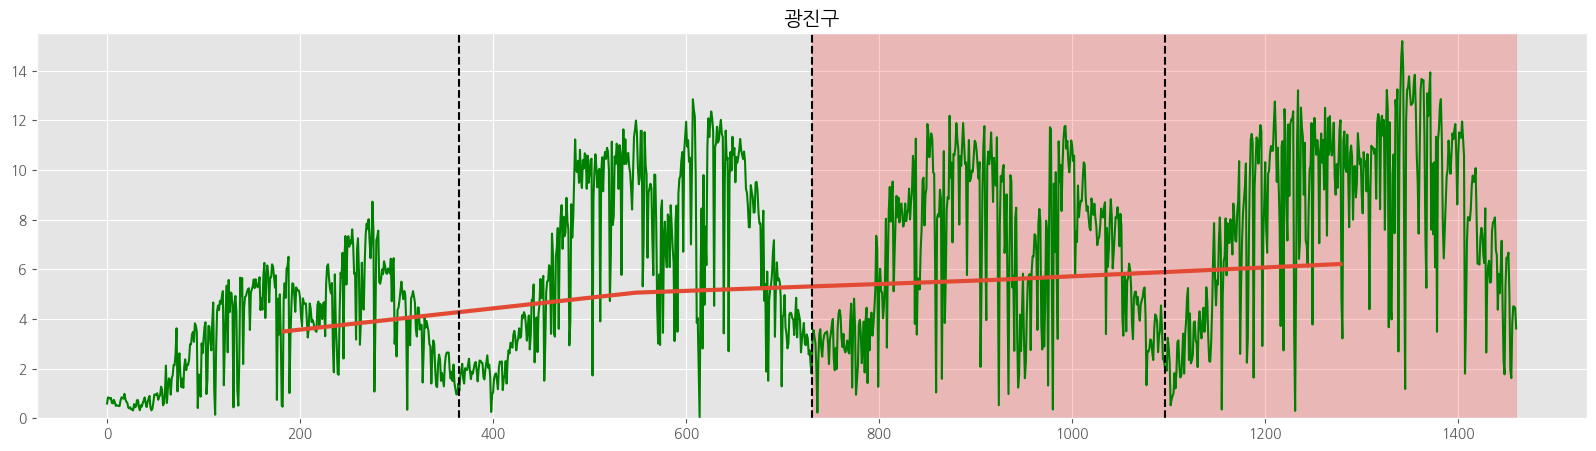

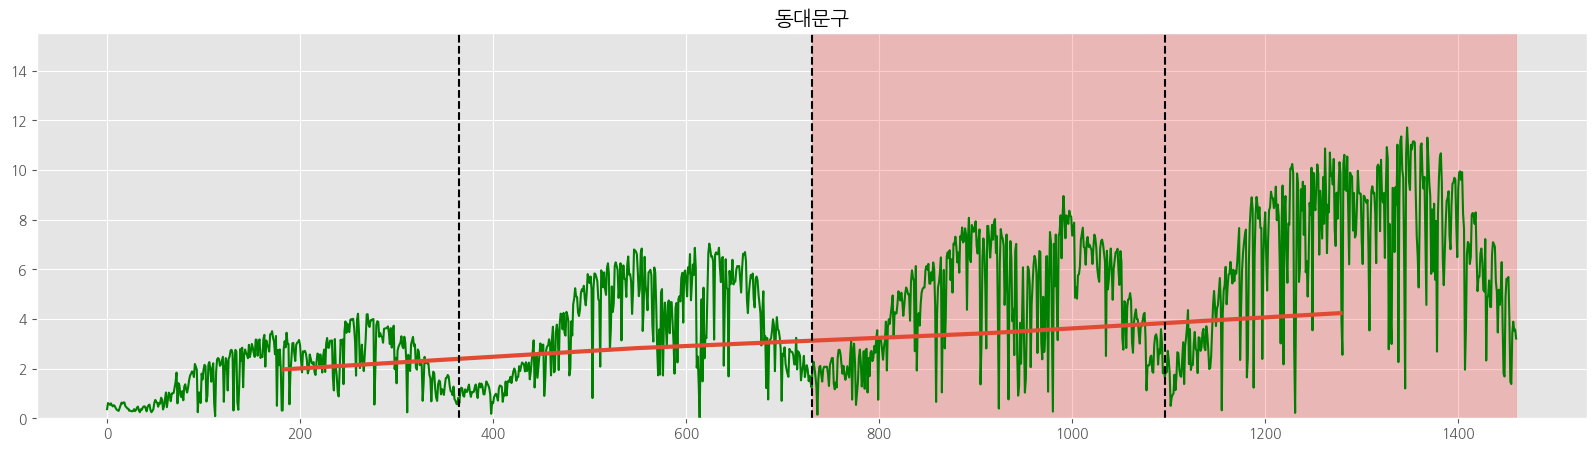

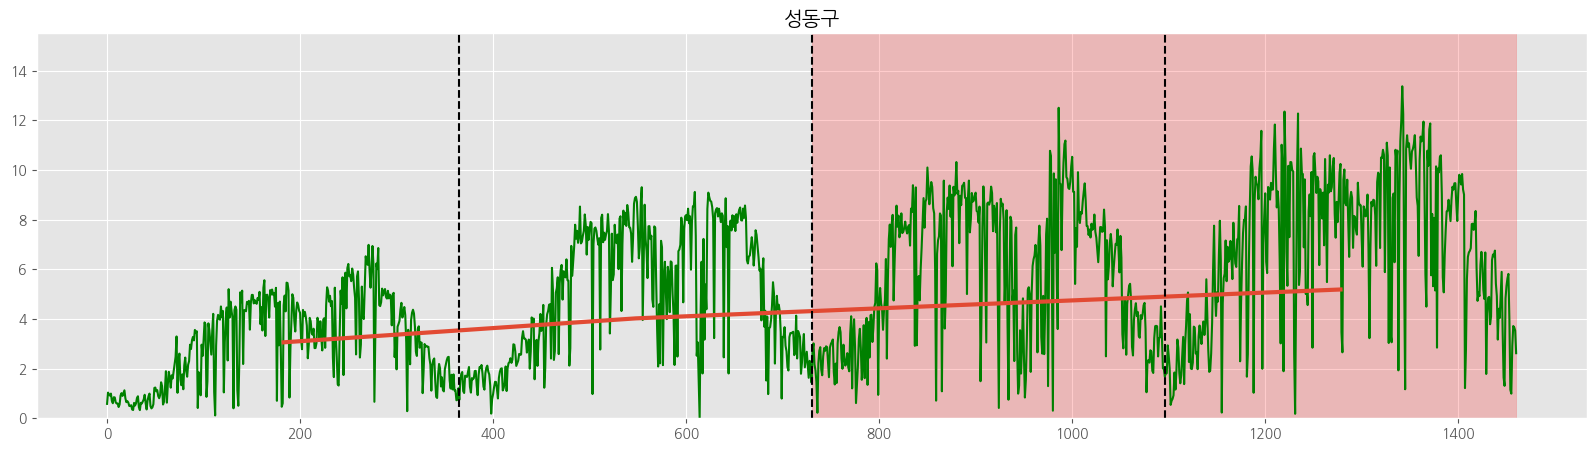

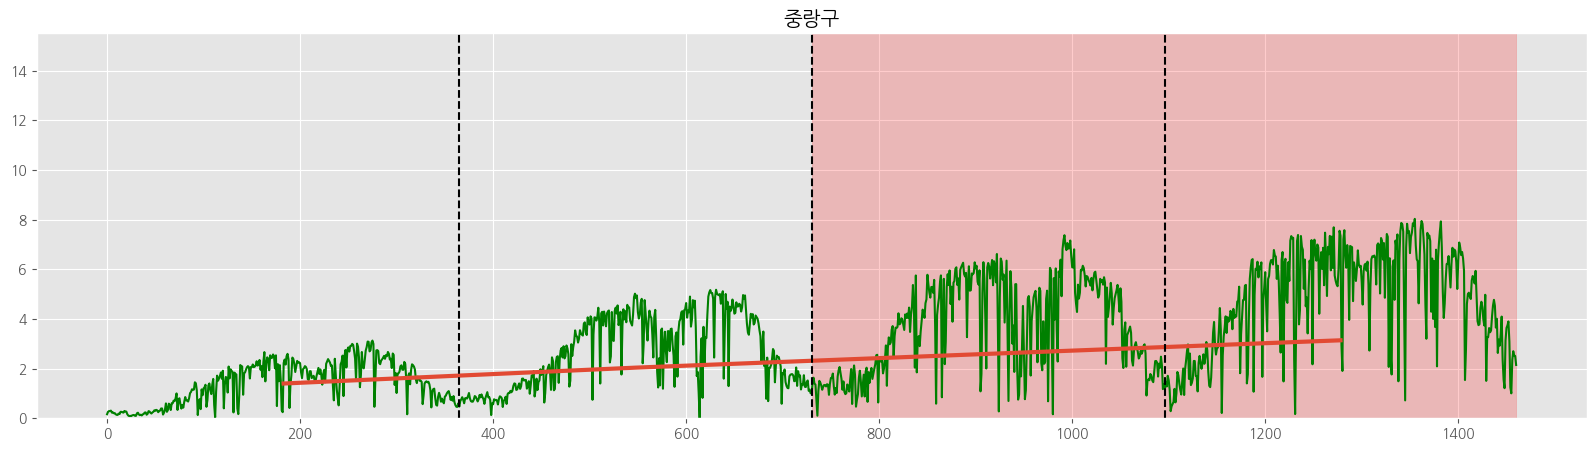

In [4]:
for i in train.columns[1:]:
    plt.figure(figsize=(20,5))
    train[i].plot(color='green')
    plt.plot([366/2+365*k for k in range(4)],[train[i][:365*(j+1)].mean() for j in range(4)],lw=3)
    plt.axvspan(365*2,365*4,color='red',alpha=0.2)
    plt.axvline(365,0,14,color='black',ls='--')
    plt.axvline(365*2,0,14,color='black',ls='--')
    plt.axvline(365*3+1,0,14,color='black',ls='--')
    plt.ylim(0,15.5)
    plt.title(i)
    plt.show()

→ 코로나가 발생한 2020년 이후로 따릉이 대여량이 크게 증가하는 것을 확인할 수 있다. 또한, 데이터가 특정한 주기를 갖는 시계열 데이터임을 확인하였다.

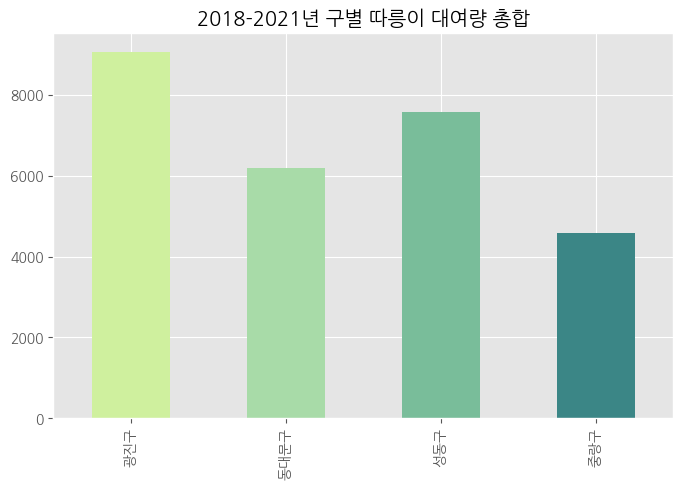

In [5]:
plt.figure(figsize=(8,5))
train.sum()[1:].plot(kind='bar',color=['#cff09e','#a8dba8','#79bd9a','#3b8686'])
plt.title('2018-2021년 구별 따릉이 대여량 총합')
plt.show()

→ 따릉이 대여량 총합은 광진구, 성동구, 동대문구, 중랑구 순으로 각 구별 대여량 scale의 차이가 있음을 확인할 수 있다.

### Feature Engineering

In [6]:
train_test = pd.concat([train,test],axis=0)
train_test

,일시,광진구,동대문구,성동구,중랑구
0,20180101,0.592,0.368,0.580,0.162
1,20180102,0.840,0.614,1.034,0.260
2,20180103,0.828,0.576,0.952,0.288
3,20180104,0.792,0.542,0.914,0.292
4,20180105,0.818,0.602,0.994,0.308
...,...,...,...,...,...
329,20221126,0.000,0.000,0.000,0.000
330,20221127,0.000,0.000,0.000,0.000
331,20221128,0.000,0.000,0.000,0.000
332,20221129,0.000,0.000,0.000,0.000


날짜를 활용하여 연,월,일,요일 feature를 생성하고 cyclical encoding을 진행하여 데이터의 주기성을 부여한다.

In [7]:
train_test['일시'] = train_test['일시'].astype(str)

In [8]:
train_test['일시'] = pd.to_datetime(train_test['일시'])

In [9]:
train_test['year'] = train_test.일시.dt.year
train_test['month'] = train_test.일시.dt.month
train_test['day'] = train_test.일시.dt.day
train_test['weekday'] = train_test.일시.dt.weekday

In [10]:
def cyclical_encoding(x, c):
    
    normalized_x = 2 * np.pi * (x / c)
    sin_x = np.sin(normalized_x)
    cos_x = np.cos(normalized_x)
    
    return sin_x, cos_x

In [11]:
train_test['month_sin'] = cyclical_encoding(train_test.month,12)[0]
train_test['month_cos'] = cyclical_encoding(train_test.month,12)[1]
train_test['day_sin'] = cyclical_encoding(train_test.day,12)[0]
train_test['day_cos'] = cyclical_encoding(train_test.day,12)[1]
train_test['weekday_sin'] = cyclical_encoding(train_test.weekday,12)[0]
train_test['weekday_cos'] = cyclical_encoding(train_test.weekday,12)[1]

추가적으로, 2020년을 기준을 코시국 여부 feature를 생성하고 평일/주말 feature도 생성한다.

In [12]:
train_test['코시국여부'] = train_test.year.apply(lambda x : 1 if x>=2020 else 0)

In [13]:
train_test['평일'] = train_test.weekday.apply(lambda x : 1 if x<5 else 0)
train_test['주말'] = train_test.weekday.apply(lambda x : 1 if x>=5 else 0)

In [14]:
train_test

,일시,광진구,동대문구,성동구,중랑구,year,month,day,weekday,month_sin,month_cos,day_sin,day_cos,weekday_sin,weekday_cos,코시국여부,평일,주말
0,2018-01-01,0.592,0.368,0.580,0.162,2018,1,1,0,0.5,0.866025,5.000000e-01,8.660254e-01,0.000000e+00,1.000000e+00,0,1,0
1,2018-01-02,0.840,0.614,1.034,0.260,2018,1,2,1,0.5,0.866025,8.660254e-01,5.000000e-01,5.000000e-01,8.660254e-01,0,1,0
2,2018-01-03,0.828,0.576,0.952,0.288,2018,1,3,2,0.5,0.866025,1.000000e+00,6.123234e-17,8.660254e-01,5.000000e-01,0,1,0
3,2018-01-04,0.792,0.542,0.914,0.292,2018,1,4,3,0.5,0.866025,8.660254e-01,-5.000000e-01,1.000000e+00,6.123234e-17,0,1,0
4,2018-01-05,0.818,0.602,0.994,0.308,2018,1,5,4,0.5,0.866025,5.000000e-01,-8.660254e-01,8.660254e-01,-5.000000e-01,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
329,2022-11-26,0.000,0.000,0.000,0.000,2022,11,26,5,-0.5,0.866025,8.660254e-01,5.000000e-01,5.000000e-01,-8.660254e-01,1,0,1
330,2022-11-27,0.000,0.000,0.000,0.000,2022,11,27,6,-0.5,0.866025,1.000000e+00,5.510911e-16,1.224647e-16,-1.000000e+00,1,0,1
331,2022-11-28,0.000,0.000,0.000,0.000,2022,11,28,0,-0.5,0.866025,8.660254e-01,-5.000000e-01,0.000000e+00,1.000000e+00,1,1,0
332,2022-11-29,0.000,0.000,0.000,0.000,2022,11,29,1,-0.5,0.866025,5.000000e-01,-8.660254e-01,5.000000e-01,8.660254e-01,1,1,0


In [15]:
train_test.drop(columns='일시',inplace=True)

train = train_test[:1461]
test = train_test[1461:]

In [16]:
train

,광진구,동대문구,성동구,중랑구,year,month,day,weekday,month_sin,month_cos,day_sin,day_cos,weekday_sin,weekday_cos,코시국여부,평일,주말
0,0.592,0.368,0.580,0.162,2018,1,1,0,5.000000e-01,0.866025,5.000000e-01,8.660254e-01,0.000000,1.000000e+00,0,1,0
1,0.840,0.614,1.034,0.260,2018,1,2,1,5.000000e-01,0.866025,8.660254e-01,5.000000e-01,0.500000,8.660254e-01,0,1,0
2,0.828,0.576,0.952,0.288,2018,1,3,2,5.000000e-01,0.866025,1.000000e+00,6.123234e-17,0.866025,5.000000e-01,0,1,0
3,0.792,0.542,0.914,0.292,2018,1,4,3,5.000000e-01,0.866025,8.660254e-01,-5.000000e-01,1.000000,6.123234e-17,0,1,0
4,0.818,0.602,0.994,0.308,2018,1,5,4,5.000000e-01,0.866025,5.000000e-01,-8.660254e-01,0.866025,-5.000000e-01,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1456,3.830,3.416,2.908,2.350,2021,12,27,0,-2.449294e-16,1.000000,1.000000e+00,5.510911e-16,0.000000,1.000000e+00,1,1,0
1457,4.510,3.890,3.714,2.700,2021,12,28,1,-2.449294e-16,1.000000,8.660254e-01,-5.000000e-01,0.500000,8.660254e-01,1,1,0
1458,4.490,3.524,3.660,2.524,2021,12,29,2,-2.449294e-16,1.000000,5.000000e-01,-8.660254e-01,0.866025,5.000000e-01,1,1,0
1459,4.444,3.574,3.530,2.506,2021,12,30,3,-2.449294e-16,1.000000,6.123234e-16,-1.000000e+00,1.000000,6.123234e-17,1,1,0


In [17]:
test

,광진구,동대문구,성동구,중랑구,year,month,day,weekday,month_sin,month_cos,day_sin,day_cos,weekday_sin,weekday_cos,코시국여부,평일,주말
0,0.0,0.0,0.0,0.0,2022,1,1,5,0.5,0.866025,5.000000e-01,8.660254e-01,5.000000e-01,-0.866025,1,0,1
1,0.0,0.0,0.0,0.0,2022,1,2,6,0.5,0.866025,8.660254e-01,5.000000e-01,1.224647e-16,-1.000000,1,0,1
2,0.0,0.0,0.0,0.0,2022,1,3,0,0.5,0.866025,1.000000e+00,6.123234e-17,0.000000e+00,1.000000,1,1,0
3,0.0,0.0,0.0,0.0,2022,1,4,1,0.5,0.866025,8.660254e-01,-5.000000e-01,5.000000e-01,0.866025,1,1,0
4,0.0,0.0,0.0,0.0,2022,1,5,2,0.5,0.866025,5.000000e-01,-8.660254e-01,8.660254e-01,0.500000,1,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
329,0.0,0.0,0.0,0.0,2022,11,26,5,-0.5,0.866025,8.660254e-01,5.000000e-01,5.000000e-01,-0.866025,1,0,1
330,0.0,0.0,0.0,0.0,2022,11,27,6,-0.5,0.866025,1.000000e+00,5.510911e-16,1.224647e-16,-1.000000,1,0,1
331,0.0,0.0,0.0,0.0,2022,11,28,0,-0.5,0.866025,8.660254e-01,-5.000000e-01,0.000000e+00,1.000000,1,1,0
332,0.0,0.0,0.0,0.0,2022,11,29,1,-0.5,0.866025,5.000000e-01,-8.660254e-01,5.000000e-01,0.866025,1,1,0


#### 외부데이터 MAPPING

기상데이터  
[기상청 기상자료개방포털] https://data.kma.go.kr/climate/RankState/selectRankStatisticsDivisionList.do

2022년에 해당하는 test 데이터에는 2000년부터 2017년까지의 기상청 데이터의 통계값을 활용하여 feature를 생성한다.

In [18]:
# 2018~2021년 기온 데이터
df1 = pd.read_csv('2018_2021_기온.csv',encoding='euc-kr')
# column명 오류 수정
df1.columns = ['지점번호','지점명','일시','평균기온','최고기온','최고기온시각','최저기온','최저기온시각','일교차']
df1

,지점번호,지점명,일시,평균기온,최고기온,최고기온시각,최저기온,최저기온시각,일교차
0,108,서울,2018-01-01,-1.3,3.8,15:38,-5.1,7:39,8.9
1,108,서울,2018-01-02,-1.8,1.8,13:45,-4.3,23:48,6.1
2,108,서울,2018-01-03,-4.7,-0.4,15:50,-7.1,8:04,6.7
3,108,서울,2018-01-04,-4.7,-0.7,15:19,-8.7,7:51,8.0
4,108,서울,2018-01-05,-3.0,1.6,15:30,-5.6,3:06,7.2
...,...,...,...,...,...,...,...,...,...
1456,108,서울,2021-12-27,-7.6,-3.9,16:34,-12.9,1:23,9.0
1457,108,서울,2021-12-28,-4.1,-0.9,16:00,-8.5,7:12,7.6
1458,108,서울,2021-12-29,0.4,5.9,15:18,-3.8,1:54,9.7
1459,108,서울,2021-12-30,-3.9,0.2,15:31,-6.8,7:14,7.0


In [19]:
# 2000년~2017년 기온 데이터
df2 = pd.read_csv('2000_2017_기온.csv',encoding='euc-kr')
# column명 오류 수정
df2.columns = ['지점번호','지점명','일시','평균기온','최고기온','최고기온시각','최저기온','최저기온시각','일교차']
df2

,지점번호,지점명,일시,평균기온,최고기온,최고기온시각,최저기온,최저기온시각,일교차
0,108,서울,2000-01-01,5.5,9.9,14:41,1.8,6:15,8.1
1,108,서울,2000-01-02,4.2,6.9,0:27,-0.9,23:59,7.8
2,108,서울,2000-01-03,-2.2,0.1,14:25,-4.6,8:29,4.7
3,108,서울,2000-01-04,0.3,4.3,15:10,-4.3,5:35,8.6
4,108,서울,2000-01-05,2.8,4.6,23:11,0.1,7:36,4.5
...,...,...,...,...,...,...,...,...,...
6570,108,서울,2017-12-27,-6.9,-2.6,15:17,-10.3,8:26,7.7
6571,108,서울,2017-12-28,-2.1,0.8,12:48,-6.8,2:22,7.6
6572,108,서울,2017-12-29,2.1,6.0,14:23,-0.4,23:47,6.4
6573,108,서울,2017-12-30,1.4,4.5,14:15,-1.2,3:30,5.7


In [20]:
# 2018~2021년 강수량 데이터
df3 = pd.read_csv('2018_2021_강수량.csv',encoding='euc-kr')
df3

,지점번호,지점명,일시,강수량(mm),1시간최다강수량(mm),1시간최다강수량시각
0,108,서울,2018-01-01,NaN,NaN,NaN
1,108,서울,2018-01-02,NaN,NaN,NaN
2,108,서울,2018-01-03,NaN,NaN,NaN
3,108,서울,2018-01-04,NaN,NaN,NaN
4,108,서울,2018-01-05,NaN,NaN,NaN
...,...,...,...,...,...,...
1456,108,서울,2021-12-27,0.0,NaN,NaN
1457,108,서울,2021-12-28,NaN,NaN,NaN
1458,108,서울,2021-12-29,0.2,NaN,NaN
1459,108,서울,2021-12-30,0.0,NaN,NaN


In [21]:
df3 = df3[['일시','강수량(mm)']]
df3['강수량(mm)'].fillna(0,inplace=True)
df3.columns=['일시','강수량']
df3

,일시,강수량
0,2018-01-01,0.0
1,2018-01-02,0.0
2,2018-01-03,0.0
3,2018-01-04,0.0
4,2018-01-05,0.0
...,...,...
1456,2021-12-27,0.0
1457,2021-12-28,0.0
1458,2021-12-29,0.2
1459,2021-12-30,0.0


In [22]:
# 2000~2017년 강수량 데이터
df4 = pd.read_csv('2000_2017_강수량.csv',encoding='euc-kr')
df4

,지점번호,지점명,일시,강수량(mm),1시간최다강수량(mm),1시간최다강수량시각
0,108,서울,2000-01-01,NaN,NaN,NaN
1,108,서울,2000-01-02,6.0,NaN,NaN
2,108,서울,2000-01-03,NaN,NaN,NaN
3,108,서울,2000-01-04,NaN,NaN,NaN
4,108,서울,2000-01-05,18.4,NaN,NaN
...,...,...,...,...,...,...
6570,108,서울,2017-12-27,NaN,NaN,NaN
6571,108,서울,2017-12-28,0.0,NaN,NaN
6572,108,서울,2017-12-29,0.0,NaN,NaN
6573,108,서울,2017-12-30,0.7,NaN,NaN


In [23]:
df4 = df4[['일시','강수량(mm)']]
df4['강수량(mm)'].fillna(0,inplace=True)
df4.columns=['일시','강수량']
df4

,일시,강수량
0,2000-01-01,0.0
1,2000-01-02,6.0
2,2000-01-03,0.0
3,2000-01-04,0.0
4,2000-01-05,18.4
...,...,...
6570,2017-12-27,0.0
6571,2017-12-28,0.0
6572,2017-12-29,0.0
6573,2017-12-30,0.7


In [24]:
train = pd.concat([train,df1[['평균기온','최고기온','최저기온','일교차']]],axis=1)
train = pd.concat([train,df3['강수량']],axis=1)
train

,광진구,동대문구,성동구,중랑구,year,month,day,weekday,month_sin,month_cos,...,weekday_sin,weekday_cos,코시국여부,평일,주말,평균기온,최고기온,최저기온,일교차,강수량
0,0.592,0.368,0.580,0.162,2018,1,1,0,5.000000e-01,0.866025,...,0.000000,1.000000e+00,0,1,0,-1.3,3.8,-5.1,8.9,0.0
1,0.840,0.614,1.034,0.260,2018,1,2,1,5.000000e-01,0.866025,...,0.500000,8.660254e-01,0,1,0,-1.8,1.8,-4.3,6.1,0.0
2,0.828,0.576,0.952,0.288,2018,1,3,2,5.000000e-01,0.866025,...,0.866025,5.000000e-01,0,1,0,-4.7,-0.4,-7.1,6.7,0.0
3,0.792,0.542,0.914,0.292,2018,1,4,3,5.000000e-01,0.866025,...,1.000000,6.123234e-17,0,1,0,-4.7,-0.7,-8.7,8.0,0.0
4,0.818,0.602,0.994,0.308,2018,1,5,4,5.000000e-01,0.866025,...,0.866025,-5.000000e-01,0,1,0,-3.0,1.6,-5.6,7.2,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1456,3.830,3.416,2.908,2.350,2021,12,27,0,-2.449294e-16,1.000000,...,0.000000,1.000000e+00,1,1,0,-7.6,-3.9,-12.9,9.0,0.0
1457,4.510,3.890,3.714,2.700,2021,12,28,1,-2.449294e-16,1.000000,...,0.500000,8.660254e-01,1,1,0,-4.1,-0.9,-8.5,7.6,0.0
1458,4.490,3.524,3.660,2.524,2021,12,29,2,-2.449294e-16,1.000000,...,0.866025,5.000000e-01,1,1,0,0.4,5.9,-3.8,9.7,0.2
1459,4.444,3.574,3.530,2.506,2021,12,30,3,-2.449294e-16,1.000000,...,1.000000,6.123234e-17,1,1,0,-3.9,0.2,-6.8,7.0,0.0


In [25]:
df2['일시'] = pd.to_datetime(df2['일시'])
df2['month'] = df2['일시'].dt.month
df2['day'] = df2['일시'].dt.day
df2['month_day'] = df2['month'].astype(str) + '_' + df2['day'].astype(str)
df2

,지점번호,지점명,일시,평균기온,최고기온,최고기온시각,최저기온,최저기온시각,일교차,month,day,month_day
0,108,서울,2000-01-01,5.5,9.9,14:41,1.8,6:15,8.1,1,1,1_1
1,108,서울,2000-01-02,4.2,6.9,0:27,-0.9,23:59,7.8,1,2,1_2
2,108,서울,2000-01-03,-2.2,0.1,14:25,-4.6,8:29,4.7,1,3,1_3
3,108,서울,2000-01-04,0.3,4.3,15:10,-4.3,5:35,8.6,1,4,1_4
4,108,서울,2000-01-05,2.8,4.6,23:11,0.1,7:36,4.5,1,5,1_5
...,...,...,...,...,...,...,...,...,...,...,...,...
6570,108,서울,2017-12-27,-6.9,-2.6,15:17,-10.3,8:26,7.7,12,27,12_27
6571,108,서울,2017-12-28,-2.1,0.8,12:48,-6.8,2:22,7.6,12,28,12_28
6572,108,서울,2017-12-29,2.1,6.0,14:23,-0.4,23:47,6.4,12,29,12_29
6573,108,서울,2017-12-30,1.4,4.5,14:15,-1.2,3:30,5.7,12,30,12_30


In [26]:
# 월-일 별 기온 데이터의 평균값 dictionary 생성
weather_dict = dict(df2.groupby('month_day')[['평균기온','최고기온','최저기온','일교차']].mean())
weather_dict

{'평균기온': month_day
 10_1     18.411111
 10_10    17.494444
 10_11    16.572222
 10_12    15.672222
 10_13    15.555556
            ...    
 9_5      23.261111
 9_6      22.588889
 9_7      22.900000
 9_8      23.005556
 9_9      22.127778
 Name: 평균기온, Length: 366, dtype: float64,
 '최고기온': month_day
 10_1     22.800000
 10_10    22.322222
 10_11    21.277778
 10_12    20.888235
 10_13    20.905556
            ...    
 9_5      27.100000
 9_6      26.966667
 9_7      27.450000
 9_8      27.461111
 9_9      26.105556
 Name: 최고기온, Length: 366, dtype: float64,
 '최저기온': month_day
 10_1     14.433333
 10_10    13.216667
 10_11    12.422222
 10_12    11.361111
 10_13    10.705556
            ...    
 9_5      20.022222
 9_6      19.133333
 9_7      18.861111
 9_8      19.405556
 9_9      18.755556
 Name: 최저기온, Length: 366, dtype: float64,
 '일교차': month_day
 10_1      8.366667
 10_10     9.105556
 10_11     8.855556
 10_12     9.376471
 10_13    10.200000
            ...    
 9_5       7.077778

In [27]:
test['month_day'] = test.month.astype(str) + '_' + test.day.astype(str)
test['평균기온'] = test.month_day.apply(lambda x : weather_dict['평균기온'][x])
test['최고기온'] = test.month_day.apply(lambda x : weather_dict['최고기온'][x])
test['최저기온'] = test.month_day.apply(lambda x : weather_dict['최저기온'][x])
test['일교차'] = test.month_day.apply(lambda x : weather_dict['일교차'][x])
test

,광진구,동대문구,성동구,중랑구,year,month,day,weekday,month_sin,month_cos,...,weekday_sin,weekday_cos,코시국여부,평일,주말,month_day,평균기온,최고기온,최저기온,일교차
0,0.0,0.0,0.0,0.0,2022,1,1,5,0.5,0.866025,...,5.000000e-01,-0.866025,1,0,1,1_1,-2.166667,1.377778,-5.577778,6.955556
1,0.0,0.0,0.0,0.0,2022,1,2,6,0.5,0.866025,...,1.224647e-16,-1.000000,1,0,1,1_2,-1.833333,1.988889,-5.333333,7.322222
2,0.0,0.0,0.0,0.0,2022,1,3,0,0.5,0.866025,...,0.000000e+00,1.000000,1,1,0,1_3,-1.772222,2.233333,-5.300000,7.533333
3,0.0,0.0,0.0,0.0,2022,1,4,1,0.5,0.866025,...,5.000000e-01,0.866025,1,1,0,1_4,-2.344444,1.711111,-5.655556,7.366667
4,0.0,0.0,0.0,0.0,2022,1,5,2,0.5,0.866025,...,8.660254e-01,0.500000,1,1,0,1_5,-2.422222,1.494444,-5.966667,7.461111
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
329,0.0,0.0,0.0,0.0,2022,11,26,5,-0.5,0.866025,...,5.000000e-01,-0.866025,1,0,1,11_26,4.772222,8.372222,1.327778,7.044444
330,0.0,0.0,0.0,0.0,2022,11,27,6,-0.5,0.866025,...,1.224647e-16,-1.000000,1,0,1,11_27,4.527778,8.511111,1.011111,7.500000
331,0.0,0.0,0.0,0.0,2022,11,28,0,-0.5,0.866025,...,0.000000e+00,1.000000,1,1,0,11_28,5.133333,8.538889,1.805556,6.733333
332,0.0,0.0,0.0,0.0,2022,11,29,1,-0.5,0.866025,...,5.000000e-01,0.866025,1,1,0,11_29,4.594444,8.405556,1.500000,6.905556


In [28]:
df4['일시'] = pd.to_datetime(df4['일시'])
df4['month'] = df4['일시'].dt.month
df4['day'] = df4['일시'].dt.day
df4['month_day'] = df4['month'].astype(str) + '_' + df4['day'].astype(str)
df4

,일시,강수량,month,day,month_day
0,2000-01-01,0.0,1,1,1_1
1,2000-01-02,6.0,1,2,1_2
2,2000-01-03,0.0,1,3,1_3
3,2000-01-04,0.0,1,4,1_4
4,2000-01-05,18.4,1,5,1_5
...,...,...,...,...,...
6570,2017-12-27,0.0,12,27,12_27
6571,2017-12-28,0.0,12,28,12_28
6572,2017-12-29,0.0,12,29,12_29
6573,2017-12-30,0.7,12,30,12_30


In [29]:
# 월-일 별 기온 데이터의 평균값 dictionary 생성
weather_dict2 = dict(df4.groupby('month_day')['강수량'].mean())
weather_dict2

{'10_1': 4.083333333333333,
 '10_10': 1.4055555555555557,
 '10_11': 1.8111111111111111,
 '10_12': 0.44999999999999996,
 '10_13': 1.7222222222222223,
 '10_14': 0.4388888888888889,
 '10_15': 1.5,
 '10_16': 0.3888888888888889,
 '10_17': 0.9222222222222223,
 '10_18': 0.01666666666666667,
 '10_19': 0.9166666666666666,
 '10_2': 2.716666666666667,
 '10_20': 1.25,
 '10_21': 2.138888888888889,
 '10_22': 3.9166666666666665,
 '10_23': 1.3277777777777777,
 '10_24': 1.5333333333333334,
 '10_25': 3.1500000000000004,
 '10_26': 0.6111111111111112,
 '10_27': 3.9166666666666665,
 '10_28': 2.1444444444444444,
 '10_29': 0.3333333333333333,
 '10_3': 1.15,
 '10_30': 0.005555555555555556,
 '10_31': 2.3277777777777775,
 '10_4': 0.6944444444444444,
 '10_5': 0.16666666666666666,
 '10_6': 0.3888888888888889,
 '10_7': 1.2777777777777777,
 '10_8': 0.5,
 '10_9': 2.111111111111111,
 '11_1': 1.6111111111111112,
 '11_10': 1.2222222222222223,
 '11_11': 3.0555555555555554,
 '11_12': 0.7166666666666667,
 '11_13': 1.83333

In [30]:
test['강수량'] = test.month_day.apply(lambda x : weather_dict2[x])
test.drop(columns='month_day',inplace=True)
test

,광진구,동대문구,성동구,중랑구,year,month,day,weekday,month_sin,month_cos,...,weekday_sin,weekday_cos,코시국여부,평일,주말,평균기온,최고기온,최저기온,일교차,강수량
0,0.0,0.0,0.0,0.0,2022,1,1,5,0.5,0.866025,...,5.000000e-01,-0.866025,1,0,1,-2.166667,1.377778,-5.577778,6.955556,0.250000
1,0.0,0.0,0.0,0.0,2022,1,2,6,0.5,0.866025,...,1.224647e-16,-1.000000,1,0,1,-1.833333,1.988889,-5.333333,7.322222,0.622222
2,0.0,0.0,0.0,0.0,2022,1,3,0,0.5,0.866025,...,0.000000e+00,1.000000,1,1,0,-1.772222,2.233333,-5.300000,7.533333,0.177778
3,0.0,0.0,0.0,0.0,2022,1,4,1,0.5,0.866025,...,5.000000e-01,0.866025,1,1,0,-2.344444,1.711111,-5.655556,7.366667,0.800000
4,0.0,0.0,0.0,0.0,2022,1,5,2,0.5,0.866025,...,8.660254e-01,0.500000,1,1,0,-2.422222,1.494444,-5.966667,7.461111,1.044444
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
329,0.0,0.0,0.0,0.0,2022,11,26,5,-0.5,0.866025,...,5.000000e-01,-0.866025,1,0,1,4.772222,8.372222,1.327778,7.044444,2.088889
330,0.0,0.0,0.0,0.0,2022,11,27,6,-0.5,0.866025,...,1.224647e-16,-1.000000,1,0,1,4.527778,8.511111,1.011111,7.500000,1.744444
331,0.0,0.0,0.0,0.0,2022,11,28,0,-0.5,0.866025,...,0.000000e+00,1.000000,1,1,0,5.133333,8.538889,1.805556,6.733333,2.238889
332,0.0,0.0,0.0,0.0,2022,11,29,1,-0.5,0.866025,...,5.000000e-01,0.866025,1,1,0,4.594444,8.405556,1.500000,6.905556,0.577778


### EDA

EDA Tool sweetviz를 통해 EDA report를 생성하여 최종 feature의 분포 및 상관관계를 파악한다.

In [31]:
my_report = sweetviz.analyze([train, "Train"],target_feat='광진구')

                                             |                                                                …

In [32]:
my_report.show_html('Report.html')

Report Report.html was generated! NOTEBOOK/COLAB USERS: the web browser MAY not pop up, regardless, the report IS saved in your notebook/colab files.


### Modeling

In [33]:
target = train.iloc[:,:4]
train = train.iloc[:,4:]
test = test.iloc[:,4:]

#### Tree계열 모델 : ExtraTreeRegressor

기본 ExtraTree의 성능을 확인해보자.

In [34]:
def model_scoring_cv(model, x, y, cv=10):
    start=time.time()
    score=-cross_val_score(model, x, y, cv=cv, scoring='neg_mean_absolute_error').mean()
    stop=time.time()
    print(f"Validation Time : {round(stop-start, 3)} sec")
    return score

def MAE(true, pred):
    return np.mean(np.abs(true-pred))

In [35]:
X_train, X_test, y_train, y_test = train_test_split(train,target,test_size=0.2,random_state=2020,shuffle=False) #시계열적 특성을 위해 shuffle=False로 지정
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((1168, 18), (293, 18), (1168, 4), (293, 4))

In [36]:
et = ExtraTreesRegressor(random_state=2020, n_estimators=500,max_depth=80)
et_multi = MultiOutputRegressor(et)
et_multi.fit(X_train,y_train)
pred = et_multi.predict(X_test)

In [37]:
MAE(y_test.reset_index(drop=True),pred)

광진구     2.082923
동대문구    2.247106
성동구     1.547463
중랑구     1.262330
dtype: float64

In [38]:
origin = pd.read_csv('train.csv')

In [39]:
idx = origin[-293:]['일시'].astype(str)

In [40]:
plt.style.use(['ggplot'])
matplotlib.rcParams['font.family'] ='NanumGothic'
matplotlib.rcParams['axes.unicode_minus'] =False

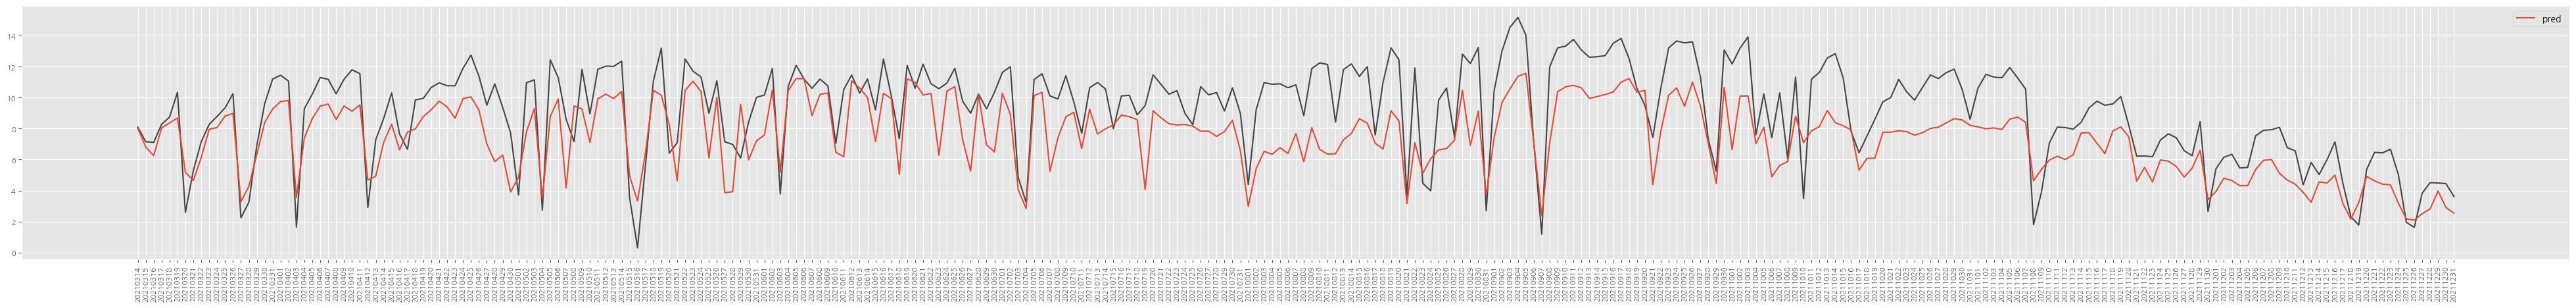

In [41]:
plt.figure(figsize=(50,5))
plt.plot(idx,y_test.iloc[:,0],color='black',alpha=0.7)
plt.plot(idx, pd.DataFrame(pred).iloc[:,0],label='pred')
plt.xticks(rotation=90)
plt.legend()
plt.show()

다소 underestimate하는 경향을 보인다. 모델이 강수량에 큰 영향을 받고 나머지 값들도 모두 underestimate하는 것으로 판단하여, 월에 따른 보정을 진행한다.

In [42]:
pred = pd.DataFrame(pred)
pred['month'] = pd.to_datetime(idx).dt.month.values
pred

,0,1,2,3,month
0,8.015320,5.675808,7.205672,4.146344,3
1,6.807332,5.175512,6.076532,3.655476,3
2,6.253288,4.995792,5.691852,3.570084,3
3,8.043720,6.161304,7.043144,4.154396,3
4,8.376056,5.658736,7.332884,4.018312,3
...,...,...,...,...,...
288,2.507300,2.169408,2.152400,1.388292,12
289,2.814512,2.302328,2.532260,1.495240,12
290,3.966512,3.451368,3.661548,2.283292,12
291,2.903608,2.353528,2.554292,1.546464,12


In [43]:
def consider_month(x,n):
    if x.month in month_winter:
        return x[n] 
    elif x.month in month_summer:
        return x[n] + 4
    else:
        return x[n] + 2

In [44]:
month_winter = [1]
month_summer = [8]

In [45]:
new_pred = pred.copy()

In [46]:
for i in range(4):
    new_pred[i] = pred.apply(lambda x : consider_month(x,i),axis=1)
    
new_pred.drop(columns='month',inplace=True)
new_pred

,0,1,2,3
0,10.015320,7.675808,9.205672,6.146344
1,8.807332,7.175512,8.076532,5.655476
2,8.253288,6.995792,7.691852,5.570084
3,10.043720,8.161304,9.043144,6.154396
4,10.376056,7.658736,9.332884,6.018312
...,...,...,...,...
288,4.507300,4.169408,4.152400,3.388292
289,4.814512,4.302328,4.532260,3.495240
290,5.966512,5.451368,5.661548,4.283292
291,4.903608,4.353528,4.554292,3.546464


In [47]:
new_pred.columns=y_test.columns

In [48]:
MAE(y_test.reset_index(drop=True),new_pred)

광진구     1.203583
동대문구    1.130758
성동구     1.327704
중랑구     1.215476
dtype: float64

보정을 진행하니 MAE 스코어가 좋아진 것을 확인할 수 있다.

전체 데이터로 재학습 후, 보정을 진행하여 최종 submission을 생성한다.

In [49]:
et = ExtraTreesRegressor(random_state=2020, n_estimators=500,max_depth=80)
et_multi = MultiOutputRegressor(et)
et_multi.fit(train,target)
pred = et_multi.predict(test)

pred = pd.DataFrame(pred)
pred['month'] = pd.to_datetime(pd.read_csv('sample_submission.csv')['일시'].astype(str)).dt.month
pred

,0,1,2,3,month
0,2.397068,1.839152,1.952300,1.397532,1
1,2.513020,2.018176,1.985996,1.524736,1
2,3.075212,2.492724,2.808660,1.668940,1
3,2.818048,2.340704,2.566944,1.532928,1
4,2.631508,2.174476,2.341000,1.445724,1
...,...,...,...,...,...
329,5.459264,4.896708,4.243572,3.495960,11
330,5.486600,4.846020,4.296204,3.467764,11
331,5.530212,5.126860,4.257124,3.394940,11
332,6.204032,5.626084,5.172860,3.842708,11


In [50]:
new_pred = pred.copy()

for i in range(4):
    new_pred[i] = pred.apply(lambda x : consider_month(x,i),axis=1)
    
new_pred.drop(columns='month',inplace=True)
new_pred

,0,1,2,3
0,2.397068,1.839152,1.952300,1.397532
1,2.513020,2.018176,1.985996,1.524736
2,3.075212,2.492724,2.808660,1.668940
3,2.818048,2.340704,2.566944,1.532928
4,2.631508,2.174476,2.341000,1.445724
...,...,...,...,...
329,7.459264,6.896708,6.243572,5.495960
330,7.486600,6.846020,6.296204,5.467764
331,7.530212,7.126860,6.257124,5.394940
332,8.204032,7.626084,7.172860,5.842708


In [51]:
sub1 = pd.read_csv('sample_submission.csv')
sub1

,일시,광진구,동대문구,성동구,중랑구
0,20220101,0,0,0,0
1,20220102,0,0,0,0
2,20220103,0,0,0,0
3,20220104,0,0,0,0
4,20220105,0,0,0,0
...,...,...,...,...,...
329,20221126,0,0,0,0
330,20221127,0,0,0,0
331,20221128,0,0,0,0
332,20221129,0,0,0,0


In [52]:
for i,k in enumerate(sub1.iloc[:,1:]):
    sub1[k] = new_pred[i]
sub1

,일시,광진구,동대문구,성동구,중랑구
0,20220101,2.397068,1.839152,1.952300,1.397532
1,20220102,2.513020,2.018176,1.985996,1.524736
2,20220103,3.075212,2.492724,2.808660,1.668940
3,20220104,2.818048,2.340704,2.566944,1.532928
4,20220105,2.631508,2.174476,2.341000,1.445724
...,...,...,...,...,...
329,20221126,7.459264,6.896708,6.243572,5.495960
330,20221127,7.486600,6.846020,6.296204,5.467764
331,20221128,7.530212,7.126860,6.257124,5.394940
332,20221129,8.204032,7.626084,7.172860,5.842708


In [53]:
#sub1.to_csv('1209_tbf_consider_et.csv',index=False)

#### 시계열 예측 모델 : Prophet

In [54]:
train = pd.read_csv('train.csv')

In [55]:
train['일시'] = pd.to_datetime(train['일시'], format='%Y%m%d')
train

,일시,광진구,동대문구,성동구,중랑구
0,2018-01-01,0.592,0.368,0.580,0.162
1,2018-01-02,0.840,0.614,1.034,0.260
2,2018-01-03,0.828,0.576,0.952,0.288
3,2018-01-04,0.792,0.542,0.914,0.292
4,2018-01-05,0.818,0.602,0.994,0.308
...,...,...,...,...,...
1456,2021-12-27,3.830,3.416,2.908,2.350
1457,2021-12-28,4.510,3.890,3.714,2.700
1458,2021-12-29,4.490,3.524,3.660,2.524
1459,2021-12-30,4.444,3.574,3.530,2.506


In [56]:
initial = ['g', 'd', 's', 'j']

In [57]:
district = list(zip(initial, train.columns.values[1:]))

In [58]:
district

[('g', '광진구'), ('d', '동대문구'), ('s', '성동구'), ('j', '중랑구')]

우선 광진구만 모델링하여 적절한 보정값을 찾는다.

In [59]:
train_g = train.loc[:, ['일시', '광진구']]

In [60]:
train_g.columns = ['ds', 'y']

In [61]:
val_g = train_g[train_g.ds >= '2021-01-01']
train_g = train_g[train_g.ds < '2021-01-01']

In [62]:
# Prophet에 시계열성 부여
m = Prophet(seasonality_mode='multiplicative',
            yearly_seasonality='auto',
            weekly_seasonality='auto',
            daily_seasonality='auto',
            holidays_prior_scale=10.0)

In [63]:
m.fit(train_g)

15:05:55 - cmdstanpy - INFO - Chain [1] start processing
15:05:55 - cmdstanpy - INFO - Chain [1] done processing


In [64]:
future = m.make_future_dataframe(periods=365)
forecast = m.predict(future)
forecast.loc[:, ['ds', 'yhat']]

,ds,yhat
0,2018-01-01,0.689756
1,2018-01-02,0.766228
2,2018-01-03,0.700644
3,2018-01-04,0.730001
4,2018-01-05,0.786712
...,...,...
1456,2021-12-27,2.108822
1457,2021-12-28,2.289790
1458,2021-12-29,2.048676
1459,2021-12-30,2.095250


In [65]:
t = (forecast
    .loc[:, ['ds', 'yhat']]
    .merge(train_g)
)

In [66]:
plt.style.use(['ggplot'])
matplotlib.rcParams['font.family'] ='NanumGothic'
matplotlib.rcParams['axes.unicode_minus'] =False

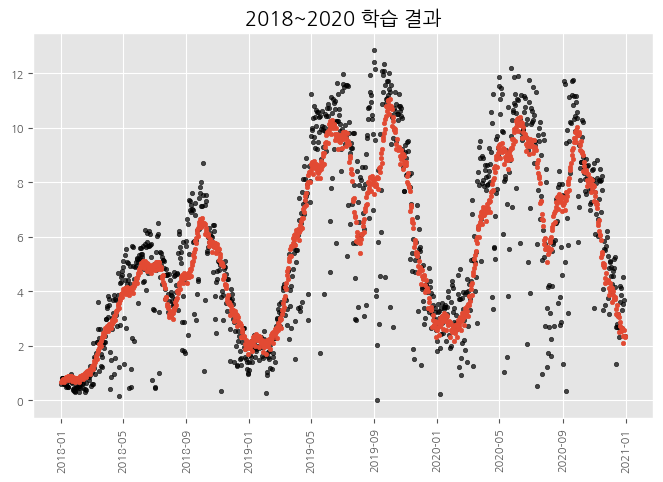

In [67]:
plt.figure(figsize=(8,5))
plt.scatter(t['ds'], t['y'], s=10, color='black', alpha=0.7)
plt.scatter(t['ds'], t['yhat'], s=10)
plt.title('2018~2020 학습 결과')
plt.xticks(rotation=90)
plt.show()

In [68]:
t = (forecast[forecast.ds >= '2021-01-01']
    .loc[:, ['ds', 'yhat']]
    .merge(val_g)
    .assign(se = lambda x: (x.yhat - x.y)**2)
)

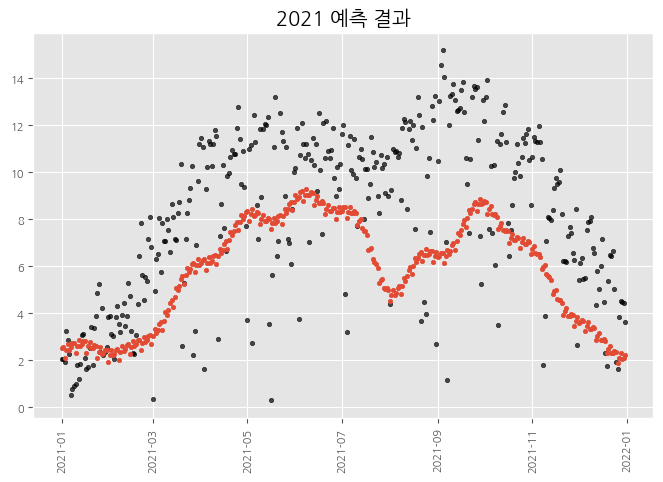

In [70]:
plt.figure(figsize=(8,5))
plt.scatter(t['ds'], t['y'], s=10,color='black',alpha=0.7)
plt.scatter(t['ds'], t['yhat'], s=10)
plt.title('2021 예측 결과')
plt.xticks(rotation=90)
plt.show()

In [68]:
t['se'].mean()

12.576221562881827

오차를 줄이기 위해 보정을 진행한다.

In [71]:
t = (forecast[forecast.ds >= '2021-01-01']
    .loc[:, ['ds', 'yhat']]
    .merge(val_g)
    .assign(yhat = lambda x: x.yhat + 3)
    .assign(se = lambda x: (x.yhat - x.y)**2)
)

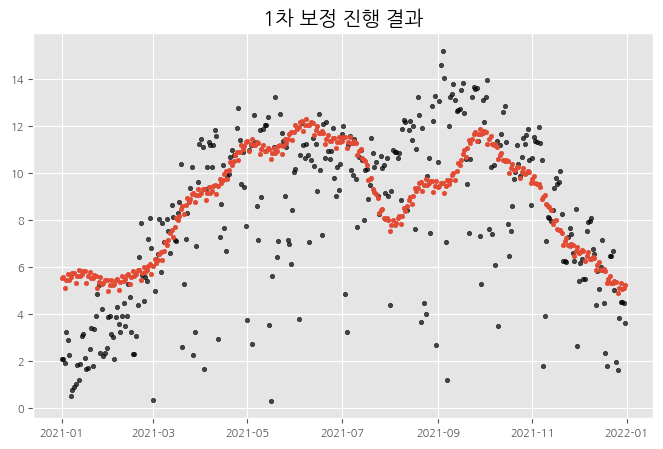

In [72]:
plt.figure(figsize=(8,5))
plt.scatter(t['ds'], t['y'], s=10,color='black',alpha=0.7)
plt.scatter(t['ds'], t['yhat'], s=10)
plt.title('1차 보정 진행 결과')
plt.show()

In [73]:
t['se'].mean()

7.441856106114976

결과 그래프를 보고 값을 수정하며 최적의 보정값을 찾아낸다.

In [74]:
month_winter = [1]
month_summer = [8]

In [75]:
def consider_month(x):
    if x.ds.month in month_winter:
        return x.yhat 
    elif x.ds.month in month_summer:
        return x.yhat + 6
    else:
        return x.yhat + 3

In [76]:
t = (forecast[forecast.ds >= '2021-01-01']
    .loc[:, ['ds', 'yhat']]
    .merge(val_g)
    )

t['yhat'] = t.apply(lambda x: consider_month(x), axis=1)
t['se'] = (t.yhat - t.y)**2

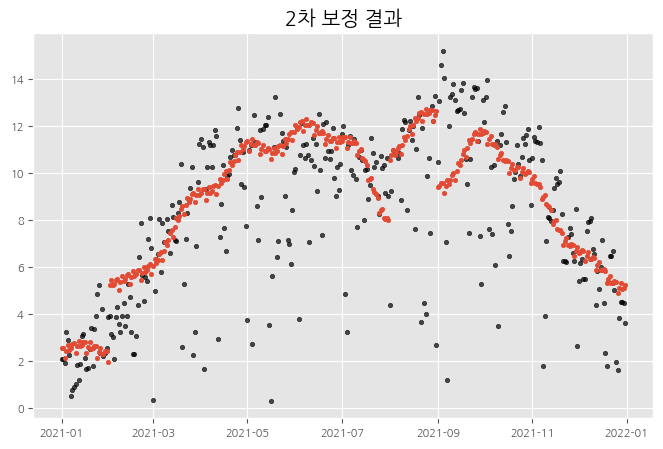

In [77]:
plt.figure(figsize=(8,5))
plt.scatter(t['ds'], t['y'], s=10,color='black',alpha=0.7)
plt.scatter(t['ds'], t['yhat'], s=10)
plt.title('2차 보정 결과')
plt.show()

In [76]:
t['se'].mean()

6.898193775027349

2차 보정 결과, 오차가 많이 줄어들고 적절한 예측값을 뽑는 것을 확인할 수 있다.

In [78]:
def train_test_split(train_d, date :str):
    
    train_d.columns = ['ds', 'y']
    
    val_d = train_d[train_d.ds >= date]
    train_d = train_d[train_d.ds < date]
    
    return train_d, val_d

In [79]:
def make_model():
    
    m = Prophet(seasonality_mode='multiplicative',
            yearly_seasonality='auto',
            weekly_seasonality='auto',
            daily_seasonality='auto',
            holidays_prior_scale=10.0)
    
    return m

In [80]:
for i, (_, d) in enumerate(district):
    print(i, d)

0 광진구
1 동대문구
2 성동구
3 중랑구


구별 따릉이 대여량의 scale이 다르므로, 보정값의 scale을 달리하기 위해 광진구와 동대문구, 성동구와 중랑구로 나누어 보정을 진행한다.

- 광진구, 동대문구

In [81]:
month_winter = [1]
month_summer = [8]

In [82]:
def consider_month(x):
    if x.ds.month in month_winter:
        return x.yhat 
    elif x.ds.month in month_summer:
        return x.yhat + 6
    else:
        return x.yhat + 3

In [83]:
def mae():
    t = (forecast[forecast.ds >= '2021-01-01']
    .loc[:, ['ds', 'yhat']]
    .merge(val_d)
    )

    t['yhat'] = t.apply(lambda x: consider_month(x), axis=1)
    t['se'] = np.abs(t.yhat - t.y)
    
    return t['se'].mean()

In [84]:
def plot_forecast():
    
    t = (forecast
        .loc[:, ['ds', 'yhat']]
        .merge(train_g)
    )
    
    t['yhat'] = t.apply(lambda x: consider_month(x), axis=1)
    t['se'] = np.abs(t.yhat - t.y)

    ax.scatter(t['ds'], t['y'], s=10, color='black',alpha=0.7)
    ax.scatter(t['ds'], t['yhat'], s=10)

In [85]:
def sub_predict():
    
    t = (forecast
         .loc[forecast.ds >= '2022-01-01', ['ds', 'yhat']]
        )
    t['yhat'] = t.apply(lambda x: consider_month(x), axis=1)

    sub2[d] = (t
         .loc[:, ['yhat']]['yhat']
         .to_numpy()
    )

In [86]:
sub2 = pd.read_csv('sample_submission.csv')

15:16:50 - cmdstanpy - INFO - Chain [1] start processing
15:16:50 - cmdstanpy - INFO - Chain [1] done processing


광진구: MAE 1.8063463914878255


15:16:51 - cmdstanpy - INFO - Chain [1] start processing
15:16:51 - cmdstanpy - INFO - Chain [1] done processing


동대문구: MAE 2.0277179262550713


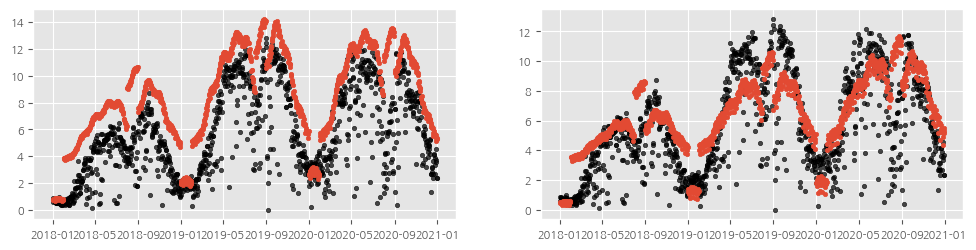

In [87]:
fig = plt.figure(figsize=(12, 6))

for i, (_, d) in enumerate(district[:2]):
    
    ax = fig.add_subplot(2,2,i+1)
    
    train_d = train.loc[:, ['일시', d]]
    
    train_d, val_d = train_test_split(train_d, '2021-01-01')
    
    m = make_model()
    
    m.fit(train_d)
    
    future = m.make_future_dataframe(periods=365*2-31)
    
    forecast = m.predict(future)
    
    forecast.yhat = np.where(forecast.yhat < 0, 0, forecast.yhat)
    
    metric = mae()
    
    print(f'{d}: MAE {metric}')
    
    plot_forecast()
    
    sub_predict()

- 성동구, 중랑구

In [88]:
def consider_month2(x):
    if x.ds.month in [1,2]:
        return x.yhat 
    elif x.ds.month in month_summer:
        return x.yhat + 5.5
    else:
        return x.yhat + 3

In [89]:
def mae2():
    t = (forecast[forecast.ds >= '2021-01-01']
    .loc[:, ['ds', 'yhat']]
    .merge(val_d)
    )

    t['yhat'] = t.apply(lambda x: consider_month2(x), axis=1)
    t['se'] = np.abs(t.yhat - t.y)
    
    return t['se'].mean()

In [90]:
def plot_forecast2():
    
    t = (forecast
        .loc[:, ['ds', 'yhat']]
        .merge(train_g)
    )
    
    t['yhat'] = t.apply(lambda x: consider_month2(x), axis=1)
    t['se'] = np.abs(t.yhat - t.y)

    ax.scatter(t['ds'], t['y'], s=10, color='black',alpha=0.7)
    ax.scatter(t['ds'], t['yhat'], s=10)

In [91]:
def sub_predict2():
    
    t = (forecast
         .loc[forecast.ds >= '2022-01-01', ['ds', 'yhat']]
        )
    t['yhat'] = t.apply(lambda x: consider_month2(x), axis=1)

    sub2[d] = (t
         .loc[:, ['yhat']]['yhat']
         .to_numpy()
    )

15:16:52 - cmdstanpy - INFO - Chain [1] start processing
15:16:52 - cmdstanpy - INFO - Chain [1] done processing


성동구: MAE 2.408873750406698


15:16:53 - cmdstanpy - INFO - Chain [1] start processing
15:16:54 - cmdstanpy - INFO - Chain [1] done processing


중랑구: MAE 2.792291774161852


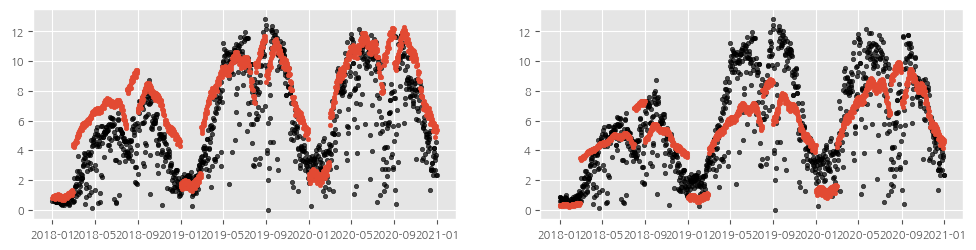

In [92]:
fig = plt.figure(figsize=(12, 6))

for i, (_, d) in enumerate(district[2:]):
    
    ax = fig.add_subplot(2,2,i+1)
    
    train_d = train.loc[:, ['일시', d]]
    
    train_d, val_d = train_test_split(train_d, '2021-01-01')
    
    m = make_model()
    
    m.fit(train_d)
    
    future = m.make_future_dataframe(periods=365*2-31)
    
    forecast = m.predict(future)
    
    forecast.yhat = np.where(forecast.yhat < 0, 0, forecast.yhat)
    
    metric = mae2()
    
    print(f'{d}: MAE {metric}')
    
    plot_forecast2()
    
    sub_predict2()

In [93]:
sub2

,일시,광진구,동대문구,성동구,중랑구
0,20220101,2.235738,2.194571,2.388499,2.055112
1,20220102,1.838252,1.589996,2.044017,1.497861
2,20220103,2.105466,2.601973,2.599862,1.899331
3,20220104,2.331849,3.039997,2.888089,2.316883
4,20220105,2.131580,2.660507,2.489096,2.056484
...,...,...,...,...,...
329,20221126,6.457441,7.771698,7.403075,7.226829
330,20221127,6.051856,7.001936,6.958452,6.483654
331,20221128,6.232266,8.069549,7.471391,6.868727
332,20221129,6.378125,8.487887,7.703525,7.276792


In [94]:
#sub2.to_csv('1206_prophet_banban.csv', index=False)

### Ensemble

각각의 submission 제출 결과(public score)는 아래와 같다.  
- sub1('1209_tbf_consider_et.csv') = 1.8440434751  
- sub2('1206_prophet_banban.csv') = 1.9791359471   

</br>이에 더 좋은 성능을 낸 sub1에 가중치를 크게 두고 submission ensemble을 진행하여 최종 submission을 생성한다.

In [94]:
final_sub = sub1*0.6 + sub2*0.4
final_sub

,일시,광진구,동대문구,성동구,중랑구
0,20220101.0,2.332536,1.981320,2.126780,1.660564
1,20220102.0,2.243113,1.846904,2.009204,1.513986
2,20220103.0,2.687314,2.536424,2.725141,1.761096
3,20220104.0,2.623569,2.620421,2.695402,1.846510
4,20220105.0,2.431537,2.368888,2.400239,1.690028
...,...,...,...,...,...
329,20221126.0,7.058535,7.246704,6.707373,6.188308
330,20221127.0,6.912702,6.908386,6.561103,5.874120
331,20221128.0,7.011033,7.503935,6.742831,5.984455
332,20221129.0,7.473669,7.970805,7.385126,6.416341


In [95]:
final_sub.to_csv('1209_tbf_1206_prophet_banban_0604.csv',index=False)